In [83]:
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy import math
from scipy import interpolate
from scipy.signal import argrelextrema

In [84]:
## Some constants
RT = 2.479 ## kJ/mol

Here we need to try values until the activation free energy and reaction free energy matches the experimental values we are looking for. In this case we will use as reference $\Delta G^{\ddagger}=24.2 kcal/mol$ and $\Delta G^{0}=-1.9 kcal/mol$ 

In [85]:
## Off-diagonal term
H12 = 67.5 #3.842
## Alpha shift
alpha = 29.8 #4.3

Here we read and plot the data from the FEP, so it does look like a reasonable energy profile

Text(0, 0.5, 'Free energy from FEP in kT')

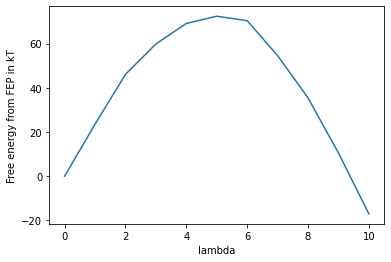

In [94]:
init = []
fep_energy = []
#fep_energy.append(0)
#init.append(0)
## Function to read and plot the results from the FEP
def load_data_fep (file):
    with open (file) as f:
        lines = f.readlines()
    for line in lines:
        if ("@" not in line) and ("#" not in line) and (" 0.0 " not in line):
            X = float(line.split()[0])
            Y = float(line.split()[1])
            init.append(X)
            fep_energy.append(Y)

## Import the FEP results

filename = 'barint.xvg'
out = load_data_fep(filename)
l = np.linspace(init[0],init[-1],len(init)+1)
plt.plot(init,fep_energy)
plt.xlabel('lambda')
plt.ylabel('Free energy from FEP in kT')

We define now a function that reads the energies from the txt files generated from the FEP

In [87]:
## Reading data from lambda function
def load_data_lambda (file):
    lambda_0=[]
    lambda_1=[]
    with open (file) as f:
        lines = f.readlines()
    for line in lines:
        X = float(line.split()[0])
        Y = float(line.split()[1])
        lambda_0.append(X)
        lambda_1.append(Y)
    return lambda_0, lambda_1


We write the EVB driver function

In [97]:
## Definition of the EVB driver
def evb_driver (lambda_0,lambda_1,l_val):
    l_t = l[l_val]
    state0 = np.array(lambda_0)
    state1 = np.array(lambda_1)+ alpha
    ## Averages 
    state0_av = np.average(state0)
    state1_av = np.average(state1)
    ## Free energy differences including alpha contribution
    dG_01 = -RT * (-state1_av + state0_av)
    ## Potential energies
    e_g = 0.5*(state1_av+state0_av)-0.5*np.sqrt((state1_av-state0_av)**2+4*H12**2) #EVB potential energy
    vi = state0_av + state1_av #-2*H12*np.sqrt(np.abs((1-l_t)*l_t)) #FEP mapping potential
    evb = np.exp(-(e_g-vi)/RT) #Probability corrected by EVB
    
    ## EVB Free energy
    dG_EVB = -RT*np.log(evb)
    print('Done for lambda:',l_val)
    return dG_EVB

In [98]:
## Calculation
#def calc (H12,alpha): ## Future feature to auto-scan the values of H12 and alpha given a dG† and dG0 ## 
        
evb_dG = []
lambdas = []
print ('Computing EVB dG per lambda...')
## Iterate the EVB driver over all the Lambdas and sort the output in a matrix [lambda,DG]
for fil in glob.glob('*.txt'):
    l_val = int(re.search(r'\d+',fil).group(0))
    lambda_0 = load_data_lambda(fil)[0]
    lambda_1 = load_data_lambda(fil)[1]
    dg_evb=evb_driver (lambda_0,lambda_1, l_val)
    evb_dG.append(dg_evb)
    lambdas.append(l_val)
a = np.array(evb_dG)
b = np.array(lambdas)
EVB_lam = np.column_stack((b,a))
EVB_lambdas = EVB_lam[EVB_lam[:,0].argsort()]    
    

Computing EVB dG per lambda...
Done for lambda: 9
Done for lambda: 8
Done for lambda: 5
Done for lambda: 4
Done for lambda: 6
Done for lambda: 7
Done for lambda: 3
Done for lambda: 2
Done for lambda: 0
Done for lambda: 1


Integration of the free energy profile

In [90]:
en = EVB_lambdas.T[1]
EVB_integral = [(en[i]+en[i-1]) for i in range(1,len(en))]
r_coord = [i for i in range(1,len(en))]

Plotting the profile

Activation free energy 24.287005503593036 kCal/mol
Reaction free energy -1.949286881651517 kCal/mol


Text(0, 0.5, 'Free energy in kCal/mol')

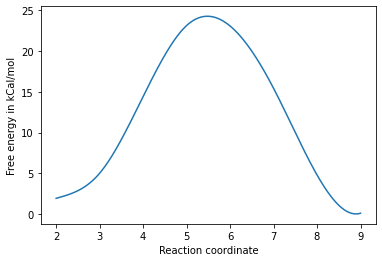

In [100]:
## Smoothening the profile with a spline
tck = interpolate.splrep (r_coord, EVB_integral,s=2)
r = np.linspace(r_coord[1],r_coord[-1],1000,endpoint=True)
profile_soft = interpolate.splev(r, tck, der=0)
plt.plot(r, profile_soft+abs(min(profile_soft)))
## Calculation of the local minima
ind = argrelextrema(profile_soft,np.less)
minima = profile_soft[ind]
## Printouts for the energies
print('Activation free energy',max(profile_soft)-minima[0],'kCal/mol')
print('Reaction free energy',-(EVB_integral[1])+(EVB_integral[-1]),'kCal/mol')
plt.xlabel('Reaction coordinate')
plt.ylabel('Free energy in kCal/mol')

Now we can save the profile and try with other solvents to see the effect